Ornstein-Uhlenbeck process follows the equation:
$$ dx_t = \theta(\mu-x_t)dt + \sqrt{2}\sigma dW_t $$
where $\theta,\mu$ and $\sigma$ are hyperparameters and $W$ is a Wiener process.
The solution is of the form:
$$ x_t = x_0e^{-\theta t} + \mu(1-e^{-\theta t}) + \frac{\sigma e^{-\theta t}}{\sqrt{\theta}} B_{e^{2\theta t}-1} $$
where $B$ is some other Wiener process.

The starting point $x_0$ will be sampled from the invariant distribution of $x$ which is $\mathcal{N}(\mu,{\sigma^2}/{\theta})$ and the trajectories will be approximated using Euler-Maruyama scheme.

In [1]:
from parameters import params

for key, value in params.items():
    print(key, value, sep=": ", end=",\n")

mu: 1,
sigma: 0.2,
theta: 1.0,
T: 330,
M: 30,
train_samples: 10000,
test_samples: 1000,
slices: 10,
latent_dim: 10,
bias: True,
layers: [100, 50],
epochs: 40,
input_dim: 30,
cond_dim: 301,


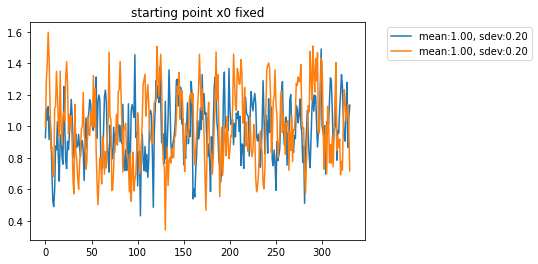

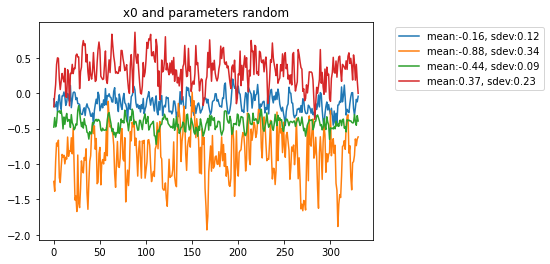

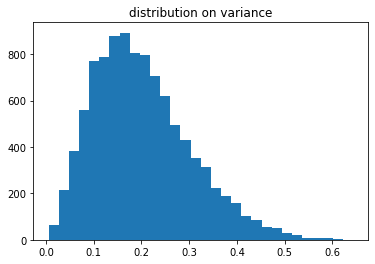

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import gen_data
from parameters import params

X0 = gen_data.stationary(size=params['train_samples'], **params)
X = gen_data.trajectory(X0, **params)
x=range(params['T']+1)

for i in range(2):
    plt.plot(x,X[i,:].T, label="mean:{:.2f}, sdev:{:.2f}".format(params['mu'],params['sigma']))
    plt.title("starting point x0 fixed")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

params2 = params.copy()
params2.update({
    'mu':  np.random.uniform(low=-1,high=1, size=params['train_samples']),
    'sigma': np.random.beta(a=3,b=12,size=params['train_samples']),
})

X = gen_data.gen_data(params2['train_samples'],save=False,**params2)
for i in range(4):
    plt.plot(x,X[i,:].T, label="mean:{:.2f}, sdev:{:.2f}".format(params2['mu'][i],params2['sigma'][i]))
    plt.title("x0 and parameters random")
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.hist(params2['sigma'], bins=30)
plt.title("distribution on variance")
plt.show()

### sanity checks

In [10]:
import torch
import gen_data
from parameters import params
from model import CVAE
import torch.nn.functional as F

X = gen_data.gen_data(params['train_samples'],save=False,**params)

set0 = gen_data.OU(X, M=params['M'])


model = CVAE(**params)
[mu1, logv1] = model.encode(set0.Y,set0.X)
z = model.sample_latent(mu, logv)
out1 = model.decode(z, set0.X)
out2, mu2, logv2 = model(set0.Y, set0.X)

MSE1 = F.mse_loss(set0.Y, out1).detach()
MSE2 = F.mse_loss(set0.Y, out2).detach()
KL1 = torch.mean(-0.5 * torch.sum(1+logv-mu**2 - logv.exp(), dim=1))   
KL2 = torch.mean(-0.5 * torch.sum(1+logv2-mu2**2 - logv2.exp(), dim=1))   
print(f'{MSE1}+{KL1}*{model.reg}={MSE1+KL1*model.reg}')
print(f'{MSE2}+{KL2}*{model.reg}={MSE2+KL2*model.reg}')

print(model.loss_func(out1, set0.Y, mu, logv))
print(model.loss_func(out2, set0.Y, mu2, logv2))

tensor([[ 0.1577,  0.0676, -0.0294,  ..., -0.0713, -0.0954,  0.0589],
        [ 0.1338,  0.0418, -0.0511,  ..., -0.1287, -0.0785,  0.0895],
        [ 0.1690,  0.0411, -0.0539,  ..., -0.0782, -0.1087,  0.1106],
        ...,
        [ 0.1541,  0.0426, -0.0154,  ..., -0.0784, -0.1162,  0.0790],
        [ 0.1121,  0.0789, -0.0335,  ..., -0.0917, -0.1373,  0.0981],
        [ 0.1786,  0.0039, -0.0488,  ..., -0.0636, -0.0951,  0.1071]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.1577,  0.0676, -0.0294,  ..., -0.0713, -0.0954,  0.0589],
        [ 0.1338,  0.0418, -0.0511,  ..., -0.1287, -0.0785,  0.0895],
        [ 0.1690,  0.0411, -0.0539,  ..., -0.0782, -0.1087,  0.1106],
        ...,
        [ 0.1541,  0.0426, -0.0154,  ..., -0.0784, -0.1162,  0.0790],
        [ 0.1121,  0.0789, -0.0335,  ..., -0.0917, -0.1373,  0.0981],
        [ 0.1786,  0.0039, -0.0488,  ..., -0.0636, -0.0951,  0.1071]],
       grad_fn=<AddmmBackward>)
1.0312868356704712+0.18122586607933044*10=2.843545436859131
1.032261

### train to sample from normal distribution with known mean and fixedvariance

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from parameters import params
from train import train
from gen_data import cvae_ds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 1, 
    'epochs': 100,
    'reg': torch.tensor(50),
    'bias': False,
    'latent_dim': 2,
    'layers': [10],
})


m = np.random.uniform(2,8, par['train_samples'])
s = [ par['sigma'] ] * par['train_samples']
Y = np.random.normal(m,s)
set0 = cvae_ds(m, Y)    
loader = DataLoader(set0, par['batch_size'])

model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
name = "data/CVAE_test_normal"
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params",par)

cuda
1: L 1138.58667 MSE 22.62863 KLD 7.15499
2: L 133.05391 MSE 2.02441 KLD 31.83355
3: L 40.64435 MSE 0.09995 KLD 35.64674
4: L 36.76187 MSE 0.07770 KLD 32.87690
5: L 33.41314 MSE 0.06918 KLD 29.95424
6: L 30.28867 MSE 0.06204 KLD 27.18674
7: L 27.63077 MSE 0.06070 KLD 24.59568
8: L 25.16305 MSE 0.05757 KLD 22.28463
9: L 23.02343 MSE 0.05627 KLD 20.20984
10: L 21.18379 MSE 0.05538 KLD 18.41469
11: L 19.42716 MSE 0.05252 KLD 16.80127
12: L 17.93368 MSE 0.05182 KLD 15.34270
13: L 16.59335 MSE 0.05114 KLD 14.03638
14: L 15.38725 MSE 0.04989 KLD 12.89274
15: L 14.48221 MSE 0.05176 KLD 11.89424
16: L 13.50862 MSE 0.05041 KLD 10.98798
17: L 12.70683 MSE 0.05042 KLD 10.18572
18: L 12.13915 MSE 0.05298 KLD 9.49019
19: L 11.51788 MSE 0.05265 KLD 8.88556
20: L 10.84318 MSE 0.05023 KLD 8.33184
21: L 10.31982 MSE 0.05027 KLD 7.80636
22: L 9.82933 MSE 0.04981 KLD 7.33882
23: L 9.37571 MSE 0.04978 KLD 6.88695
24: L 8.90017 MSE 0.04916 KLD 6.44238
25: L 8.53771 MSE 0.04899 KLD 6.08843
26: L 8.02880

torch.Size([10000, 2]),torch.Size([10000])


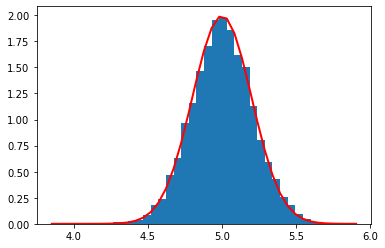

In [7]:
name = "data/CVAE_test_normal"
par = np.load(name+"_params.npy", allow_pickle=True).item()

model = CVAE(**par)

model.load_state_dict(torch.load(name+"_model"))

samples = 10000
res = model.sample_trajectories(samples, torch.tensor(5)).squeeze(1)

count, bins, _ = plt.hist(res.numpy(), 40, density=1)
plt.plot(bins, 1/(par['sigma'] * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - 5)**2 / (2 * par['sigma']**2) ),
         linewidth=2, color='r')
plt.show()

### train to sample from exp distribution with known parameter

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from parameters import params
from train import train
from gen_data import cvae_ds

par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 1, 
    'epochs': 100,
    'reg': torch.tensor(1),
    'bias': False,
    'latent_dim': 2,
    'layers': [500,100],
})


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(par['reg'])

m = np.random.uniform(2, 10, par['train_samples'])
Y = np.random.exponential(m)
set0 = cvae_ds(m, Y)
loader = DataLoader(set0, par['batch_size'])

model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
name = "data/CVAE_test_exp"
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params",par)

cuda
tensor(1)
(tensor(3.6599), tensor([0.8509]))
1: L 8.98143 MSE 5.07049 KLD 0.03911
2: L 3.48171 MSE 1.04590 KLD 0.02436
3: L 3.20562 MSE 0.91483 KLD 0.02291
4: L 3.24665 MSE 1.01602 KLD 0.02231
5: L 3.10088 MSE 0.89176 KLD 0.02209
6: L 3.08916 MSE 0.93807 KLD 0.02151
7: L 3.25044 MSE 1.06113 KLD 0.02189
8: L 2.93506 MSE 0.82449 KLD 0.02111
9: L 2.91067 MSE 0.79940 KLD 0.02111
10: L 2.88122 MSE 0.78938 KLD 0.02092
11: L 2.86492 MSE 0.81201 KLD 0.02053
12: L 2.91196 MSE 0.85183 KLD 0.02060
13: L 2.87528 MSE 0.82966 KLD 0.02046
14: L 2.79680 MSE 0.76277 KLD 0.02034
15: L 2.77106 MSE 0.76144 KLD 0.02010
16: L 2.79216 MSE 0.78733 KLD 0.02005
17: L 2.90018 MSE 0.90583 KLD 0.01994
18: L 2.75705 MSE 0.73962 KLD 0.02017
19: L 2.71469 MSE 0.72717 KLD 0.01988
20: L 2.70195 MSE 0.72633 KLD 0.01976
21: L 2.67107 MSE 0.72325 KLD 0.01948
22: L 2.68379 MSE 0.71971 KLD 0.01964
23: L 2.69114 MSE 0.71514 KLD 0.01976
24: L 2.66420 MSE 0.70749 KLD 0.01957
25: L 2.64821 MSE 0.69159 KLD 0.01957
26: L 2.6

torch.Size([10000, 2]),torch.Size([10000])


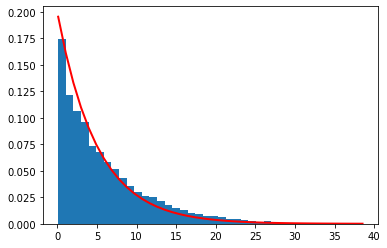

In [6]:
name = "data/CVAE_test_exp"
par = np.load(name+"_params.npy", allow_pickle=True).item()

model = CVAE(**par)

model.load_state_dict(torch.load(name+"_model"))

samples = 10000
res = model.sample_trajectories(samples, torch.tensor(6))

count, bins, _ = plt.hist(res.numpy(), 40, density=True)
plt.plot(bins, 1/5 * np.exp( - (bins / 5) ), linewidth=2, color='r')
plt.show()

### sample from normal based on big sample (guess mean and varianceabs)

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from parameters import params
from train import train
from gen_data import cvae_ds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

par = params.copy()
par.update({
    'input_dim': 1,
    'cond_dim': 10, 
    'epochs': 100,
    'reg': torch.tensor(50),
    'bias': False,
    'latent_dim': 2,
    'layers': [500,100],
})


m = np.random.uniform(2,8, par['train_samples'])
s = np.random.uniform(0.1,0.3, par['train_samples'])
X = [np.random.normal(_m,_s, par['cond_dim']) for _m,_s in zip(m,s)]
Y = np.random.normal(m,s)
set0 = cvae_ds(X, Y)
loader = DataLoader(set0, par['batch_size'])

model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
name = "data/CVAE_test_empirical_normal"
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params",par)

cuda
1: L 53.14557 MSE 0.99016 KLD 3.63760
2: L 2.46606 MSE 0.04924 KLD 0.00428
3: L 2.46347 MSE 0.04920 KLD 0.00332
4: L 2.46766 MSE 0.04930 KLD 0.00287
5: L 2.46542 MSE 0.04926 KLD 0.00254
6: L 2.47105 MSE 0.04938 KLD 0.00228
7: L 2.47266 MSE 0.04941 KLD 0.00210
8: L 2.47059 MSE 0.04937 KLD 0.00190
9: L 2.45934 MSE 0.04915 KLD 0.00166
10: L 2.45739 MSE 0.04912 KLD 0.00141
11: L 2.45873 MSE 0.04915 KLD 0.00130
12: L 2.46485 MSE 0.04928 KLD 0.00108
13: L 2.46645 MSE 0.04931 KLD 0.00095
14: L 2.47293 MSE 0.04944 KLD 0.00078
15: L 2.47140 MSE 0.04941 KLD 0.00074
16: L 2.46953 MSE 0.04938 KLD 0.00061
17: L 2.46293 MSE 0.04925 KLD 0.00049
18: L 2.46235 MSE 0.04924 KLD 0.00035
19: L 2.46439 MSE 0.04928 KLD 0.00031
20: L 2.46677 MSE 0.04933 KLD 0.00041
21: L 2.47071 MSE 0.04940 KLD 0.00065
22: L 2.47679 MSE 0.04950 KLD 0.00196
23: L 2.48617 MSE 0.04966 KLD 0.00313
24: L 2.48802 MSE 0.04936 KLD 0.01986
25: L 2.42867 MSE 0.04730 KLD 0.06373
26: L 2.10506 MSE 0.03482 KLD 0.36416
27: L 1.57737 M

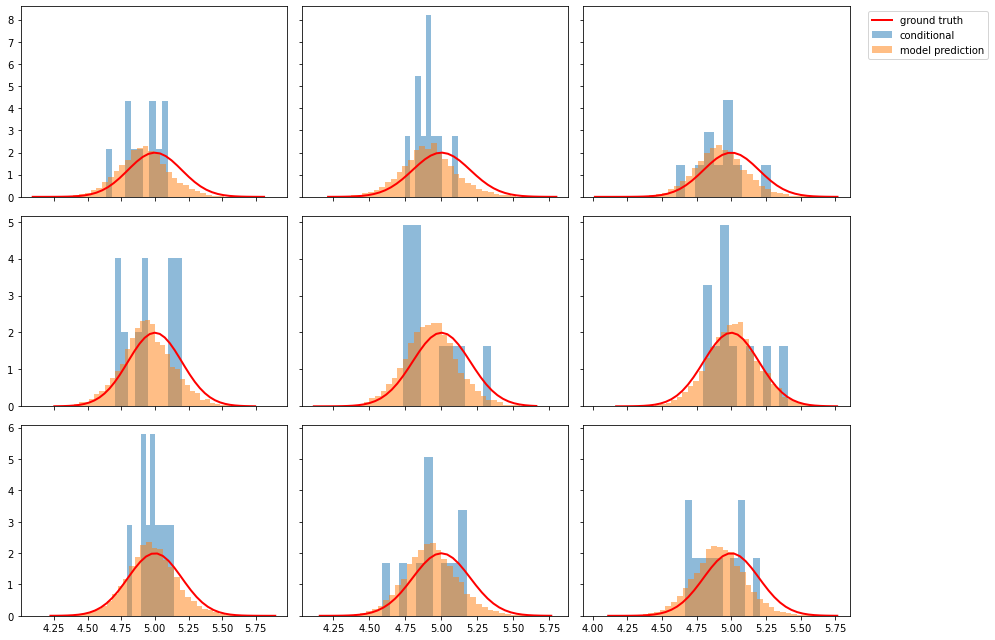

In [9]:
name = "data/CVAE_test_empirical_normal"
par = np.load(name+"_params.npy", allow_pickle=True).item()
model = CVAE(**par)
model.load_state_dict(torch.load(name+"_model"))

nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols,  
                        figsize=(nrows*4, ncols*3),
                        sharex='col', sharey='row')
for i in range(nrows):
    for j in range(ncols):
        samples = 10000
        X = torch.tensor(np.random.normal(5,par['sigma'], par['cond_dim']), dtype=torch.float32)
        res = model.sample_trajectories(samples, X)

        axs[i,j].hist(X.numpy(), density=1, alpha=0.5, label="conditional")
        count, bins, _ = axs[i,j].hist(res.numpy(), 40, alpha=0.5, density=1, label="model prediction")
        axs[i,j].plot(bins, 1/(par['sigma'] * np.sqrt(2 * np.pi)) *
                       np.exp( - (bins - 5)**2 / (2 * par['sigma']**2) ),
                 linewidth=2, color='r', label="ground truth")

fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 3.2), loc='upper left')
plt.show()

### Ornstein Uhlenbeck process with varying x0 and fixed parameters

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import gen_data
from model import CVAE
from parameters import params
from train import train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

par = params.copy()
par.update({
    'input_dim': 10,
    'cond_dim': 90, 
})

x0 = gen_data.stationary(size=par['train_samples'], **par)
XY = [gen_data.trajectory(_x0, T=par['input_dim']+par['cond_dim']-1, **par) for _x0 in x0]
X = [xy[:par['cond_dim']] for xy in XY]
Y = [xy[par['cond_dim']:] for xy in XY]

cuda


In [4]:
# save the data
name = "data/CVAE-OU"
np.save(name+"_X", X)
np.save(name+"_Y", Y)
np.save(name+"_params", par)

In [24]:
# load the data
name = "data/CVAE-OU"
X = np.load(name+"_X.npy")
Y = np.load(name+"_Y.npy")
set0 = gen_data.cvae_ds(X, Y)
loader = DataLoader(set0, par['batch_size'])

In [99]:
name = "data/CVAE-OU"
par = np.load(name+"_params.npy", allow_pickle=True).item()
par.update({
    'epochs': 100,
    'batch_size':1000,
    'reg': torch.tensor(10**5),
    'bias': False,
    'latent_dim': 100,
    'layers': [1000,500,200],
})


model = CVAE(device=device, **par).to(device)

train(model, loader, device, True, **par)

# save the results
torch.save(model.state_dict(), name+"_model")
np.save(name+"_params", par)

1: L 8988.03320 MSE 0.08987 KLD 0.70567
2: L 3985.83984 MSE 0.03981 KLD 4.93324
3: L 3031.93701 MSE 0.03008 KLD 23.60932
4: L 2921.12817 MSE 0.02884 KLD 37.22578
5: L 2923.01392 MSE 0.02888 KLD 34.60244
6: L 2899.47339 MSE 0.02866 KLD 33.33735
7: L 2871.67017 MSE 0.02840 KLD 31.85101
8: L 2866.38232 MSE 0.02836 KLD 29.88354
9: L 2838.51880 MSE 0.02810 KLD 28.70766
10: L 2853.37451 MSE 0.02825 KLD 28.20390
11: L 2800.37939 MSE 0.02772 KLD 28.72935
12: L 2710.90552 MSE 0.02679 KLD 31.97560
13: L 2068.24341 MSE 0.02016 KLD 52.66039
14: L 1795.83313 MSE 0.01737 KLD 58.34710
15: L 1523.94202 MSE 0.01459 KLD 65.34260
16: L 1455.15820 MSE 0.01392 KLD 63.11921
17: L 1430.61340 MSE 0.01372 KLD 58.36992
18: L 1431.24683 MSE 0.01376 KLD 55.66212
19: L 1451.84326 MSE 0.01398 KLD 54.02577
20: L 1386.00085 MSE 0.01331 KLD 55.41341
21: L 1282.21326 MSE 0.01219 KLD 63.23717
22: L 1164.15625 MSE 0.01099 KLD 64.71177
23: L 1126.37122 MSE 0.01065 KLD 61.59761
24: L 1094.68799 MSE 0.01035 KLD 59.82182
25:

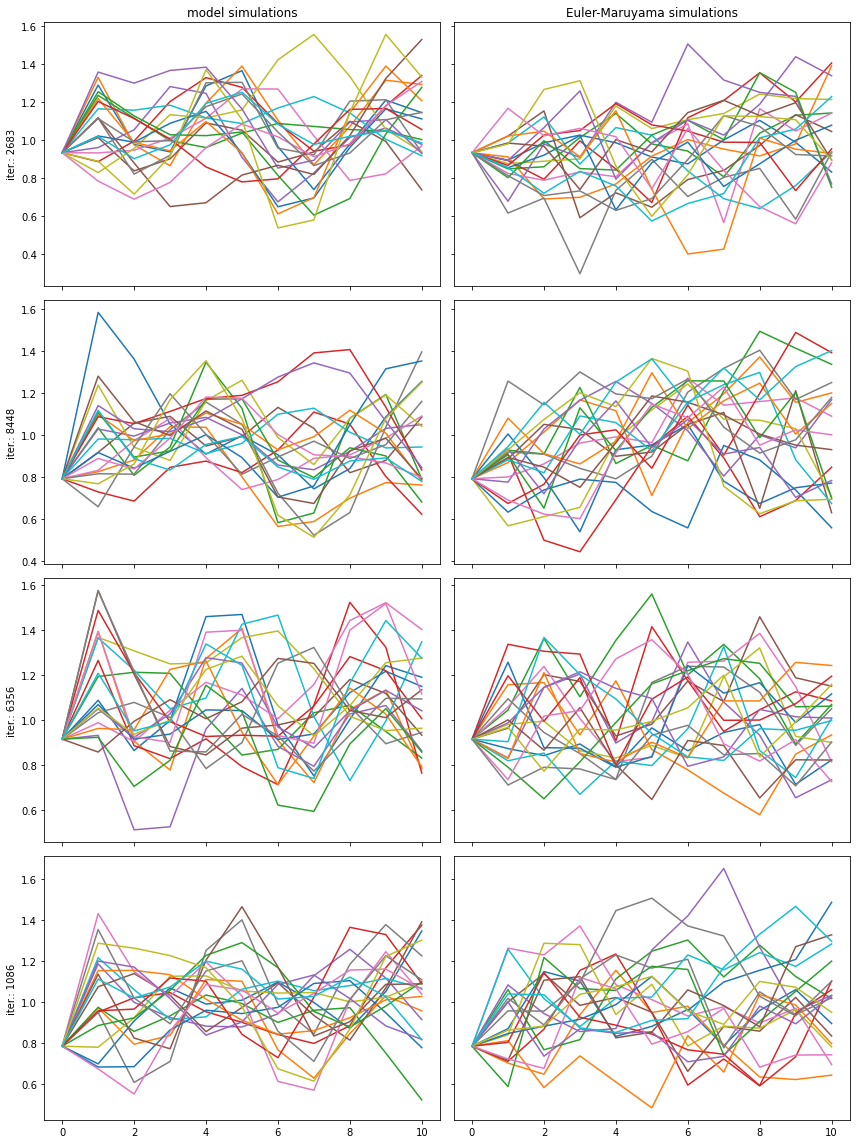

In [101]:
name = "data/CVAE-OU"
X = np.load(name+"_X.npy")
par = np.load(name+"_params.npy", allow_pickle=True).item()
model = CVAE(**par)
model.load_state_dict(torch.load(name+"_model"))


nrows = 4
ncols = 2
samples = 20
x = np.arange(0, 1+par['input_dim'])
I = np.arange(0, par['train_samples'])
np.random.shuffle(I)

fig, axs = plt.subplots(nrows, ncols,  
                        figsize=(nrows*3, nrows*4),
                        sharex='col', sharey='row')

for i in range(nrows):
    res = model.sample_trajectories(samples, torch.tensor(X[I[i]], dtype=torch.float32))

    for j in range(samples):
        axs[i,0].plot(x, np.append(X[I[i]][0], res[j].numpy()))
    
    axs[i,0].set_ylabel(f"iter.: {I[i]}")
    for j in range(samples):
        EM = gen_data.trajectory(X[I[i]][0], T=par['input_dim'], **par)
        axs[i,1].plot(x, EM)
    
axs[0,0].title.set_text("model simulations")
axs[0,1].title.set_text("Euler-Maruyama simulations")

fig.tight_layout()
plt.show()

train0


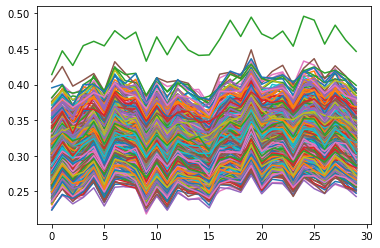

train1


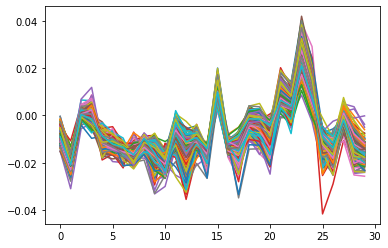

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import CVAE
from parameters import params
from gen_data import OU

sample_names=["train0","train1"]

for sample_name in sample_names:
    print(sample_name)
    name = params['name']+"-"+sample_name
    model = CVAE(**params)
    model.load_state_dict(torch.load(name+"_model"))
    mu = np.load(name+"_mu.npy")
    logvar = np.load(name+"_logvar.npy")
    set0 = OU(np.load("data/" + sample_name + ".npy"), M=params['M'])


    samples = 1000
    x = range(params['M'])
    X = model.sample_trajectories(samples, torch.zeros(params['cond_dim']))

    for i in range(samples):
        plt.plot(x,X[i,:].T)

    plt.show()